## 项目背景介绍
智能零售柜商品识别是第六届信也科技杯图像算法大赛的一个项目。该项目可以使得计算机精准地对顾客购买的商品进行智能化、自动化的价格结算。当顾客将自己选购的商品放置在制定区域的时候，一个理想的智能零售结算系统应当能够精准地识别每一个商品，并且能够返回完整地购物清单及顾客应付的实际商品总价格。

目标检测作为图像处理和计算机视觉的一个重要分支，在许多领域得到了广泛的应用。智能零售柜作为智能零售系统的典型代表，可以在无售货员状态下提供自动化销售服务。在传统的零售柜中，实现自动识别的方法主要有：硬件分隔、根据重量判断、识别顾客的行为、射频识别标记等。这些传统的方法成本高，降低了柜子的空间利用率，限制商品种类。采用商品识别技术，相比于人工扫商品的条码或者顾客自主机器扫码、以及上述各种自动识别的方式效率更高，商店也能因此提高盈利，对于顾客也能减少顾客排队等待时间，消费过程更加便捷。

项目拟使用的方法： 借鉴原有项目，在使用PaddleX进行模型训练的过程中，检测模型使用PPYolo或者YOLOv3。骨干网络采用ResNet50。数据集总数据量为5422张，共有113类商品，属于多分类问题。

## 准备工作

In [ ]:
# 解压挂载的数据集在同级目录下
!unzip -oq data/data91732/VOC.zip -d data/data91732/
print('Done') 

Done


In [ ]:
# 查看数据集的目录结构(-L  level 遍历目录的最大层数，level 为大于0的正整数)
! tree data/data91732/ -L 1

data/data91732/
├── Annotations
├── JPEGImages
├── labels.txt
├── test_list.txt
├── train_list.txt
├── val_list.txt
└── VOC.zip

2 directories, 5 files


## 数据集介绍
* 本数据集采用VOC格式，符合大多深度学习开发套件对数据集格式的要求，可满足paddlex或PaddleDetection的训练要求。本数据集总数据量为5422张，且所有图片均已标注，共有113类商品。本数据集以对数据集进行划分，其中训练集3796张、验证集1084张、测试集542张。
* 数据来源：第六届信也科技杯图像算法大赛，@Thomas-yanxin
* 归类领域：目标检测
* 数据类型：VOC（由@Thomas-yanxin转换）。
* 保存格式：数据集分为训练数据集、训练商品库。训练数据集包含图片数据及标注信息。图片数据集为密集商品图片，尺寸960x720，格式为jpg。

```
data/data91732/
├── Annotations（标记）
├── JPEGImages（图片）
├── labels.txt（商品类别，113）
├── test_list.txt（测试集，3796）
├── train_list.txt（训练集，542）
├── val_list.txt（验证集，1084）
└── VOC.zip
```

* 样本数量：训练集3796张、验证集1084张、测试集542张。
* 类别：113类商品


In [ ]:
#定义数据根目录
DATA_PATH = 'data/data91732/'

In [ ]:
# 把数据集中含有空格的数据进行重命名
import os 
path_1 = DATA_PATH + 'JPEGImages'
path_2 = DATA_PATH + 'Annotations'
file_lists = os.listdir(path_1)
# print(file_lists)
for i in file_lists:
    if " " in i:
        new = i.replace(' ','')
        os.rename(os.path.join(path_1,i),os.path.join(path_1,new))
        print(new)

file_lists = os.listdir(path_2)
# print(file_lists)
for i in file_lists:
    if " " in i:
        new = i.replace(' ','')
        os.rename(os.path.join(path_2,i),os.path.join(path_2,new))
        print(new)

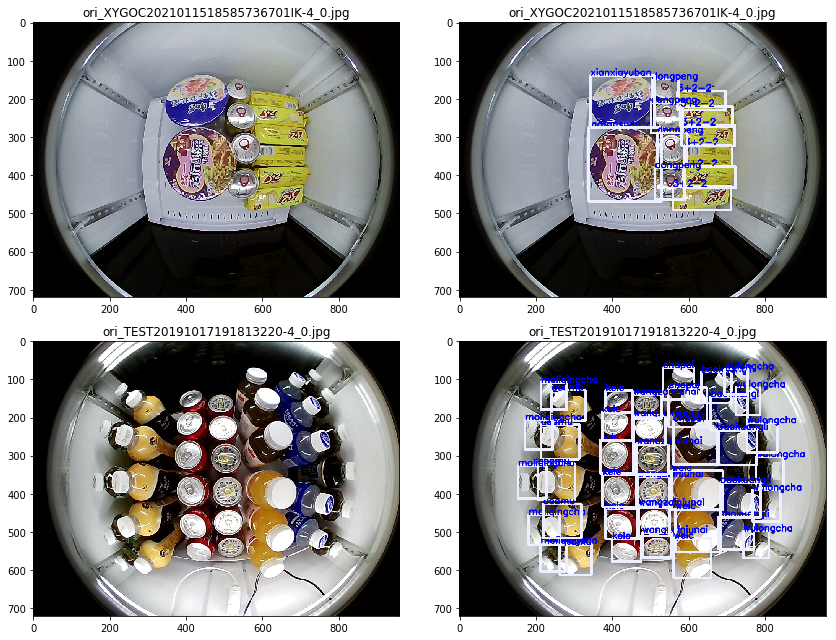

In [ ]:
# 目标检测数据集抽样可视化
import cv2
import matplotlib.pyplot as plt
import xml

%matplotlib inline

# 后来才发现直接在三个*_list.txt实现对应jpg和xml文件就行，但是在这里懒得改了，后面重新写
def show_some_result(image_path_list):
    label_path_list = [path.replace('JPEGImages', 'Annotations').replace('jpg', 'xml') for path in image_path_list]
    plt.figure(figsize=(12,9))
    for i in range(len(image_path_list)):
        plt.subplot(len(image_path_list), 2, i*2+1)
        plt.title(image_path_list[i].split('/')[-1])
        plt.imshow(cv2.imread(image_path_list[i])[:, :, ::-1])
        # 不加[:, :, ::-1]会导致颜色不对，但这不是色差问题，是cv2的图像对象使用的是bgr, plt绘图显示图像对象使用的是 rgb，逆序即可
        
        img = cv2.imread(image_path_list[i])
        dom = xml.dom.minidom.parse(label_path_list[i])
        root = dom.documentElement
        objects=dom.getElementsByTagName("object")
        for object in objects:
            bndbox = object.getElementsByTagName('bndbox')[0]
            name = object.getElementsByTagName('name')[0]
            xmin = bndbox.getElementsByTagName('xmin')[0]
            ymin = bndbox.getElementsByTagName('ymin')[0]
            xmax = bndbox.getElementsByTagName('xmax')[0]
            ymax = bndbox.getElementsByTagName('ymax')[0]
            name_data=name.childNodes[0].data
            xmin_data=xmin.childNodes[0].data
            ymin_data=ymin.childNodes[0].data
            xmax_data=xmax.childNodes[0].data
            ymax_data=ymax.childNodes[0].data
            cv2.rectangle(img,(int(xmin_data),int(ymin_data)),(int(xmax_data),int(ymax_data)),(254,238,237),5)
            cv2.putText(img, name_data, (int(xmin_data),int(ymin_data)),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
        cv2.imwrite(DATA_PATH + 'save_'+ image_path_list[i].split('/')[-1], img)
        plt.subplot(len(image_path_list), 2, i*2+2)
        plt.title(image_path_list[i].split('/')[-1])
        plt.imshow(img[:, :, ::-1])
    plt.tight_layout()
    plt.show()

image_path_list = [DATA_PATH+ 'JPEGImages/ori_XYGOC2021011518585736701IK-4_0.jpg', DATA_PATH + 'JPEGImages/ori_TEST20191017191813220-4_0.jpg']
show_some_result(image_path_list)

In [ ]:
import glob
import numpy as np

## 商品类名转数字

下面我们将从数据集中读取xml文件，将每张图片的标注信息读取出来。在读取具体的标注文件之前，我们先完成一件事情，就是将商品的类别名字（字符串）转化成数字表示的类别。因为神经网络里面计算时需要的输入类型是``数值型的，所以需要将字符串表示的类别转化成具体的数字。商品类别名称的列表是：

`['3+2-2','3jia2','aerbeisi']`

这里我们约定此列表中：'3+2-2'对应类别0，'3jia2'对应类别1，'aerbeisi'对应类别3...使用下面的程序可以得到表示名称字符串和数字类别之间映射关系的字典。

In [ ]:
def get_goods_names():
    GOODS_CATEGORY_PATH = DATA_PATH + 'labels.txt'
    goods_category2id = {}
    with open(GOODS_CATEGORY_PATH, "r") as f:
        id = 0
        for line in f.readlines():
            line = line.strip('\n')  #去掉列表中每一个元素的换行符
            goods_category2id[line] = id
            id += 1
    return goods_category2id

get_goods_names()

{'3+2-2': 0,
 '3jia2': 1,
 'aerbeisi': 2,
 'anmuxi': 3,
 'aoliao': 4,
 'asamu': 5,
 'baicha': 6,
 'baishikele': 7,
 'baishikele-2': 8,
 'baokuangli': 9,
 'binghongcha': 10,
 'bingqilinniunai': 11,
 'bingtangxueli': 12,
 'buding': 13,
 'chacui': 14,
 'chapai': 15,
 'chapai2': 16,
 'damaicha': 17,
 'daofandian1': 18,
 'daofandian2': 19,
 'daofandian3': 20,
 'daofandian4': 21,
 'dongpeng': 22,
 'dongpeng-b': 23,
 'fenda': 24,
 'gudasao': 25,
 'guolicheng': 26,
 'guolicheng2': 27,
 'haitai': 28,
 'haochidian': 29,
 'haoliyou': 30,
 'heweidao': 31,
 'heweidao2': 32,
 'heweidao3': 33,
 'hongniu': 34,
 'hongniu2': 35,
 'hongshaoniurou': 36,
 'jianjiao': 37,
 'jianlibao': 38,
 'jindian': 39,
 'kafei': 40,
 'kaomo_gali': 41,
 'kaomo_jiaoyan': 42,
 'kaomo_shaokao': 43,
 'kaomo_xiangcon': 44,
 'kebike': 45,
 'kele': 46,
 'kele-b': 47,
 'kele-b-2': 48,
 'laotansuancai': 49,
 'liaomian': 50,
 'libaojian': 51,
 'lingdukele': 52,
 'lingdukele-b': 53,
 'liziyuan': 54,
 'lujiaoxiang': 55,
 'lujikafei':

## 将图片和数据对应

In [ ]:
import os
import numpy as np
import xml.etree.ElementTree as ET

def get_annotations(name2id, image_data_dir):

    id = 0
    records = []
    with open(image_data_dir, "r") as f:
        for line in f.readlines():
            img_path, data_path = line.strip('\n').split()  #去掉列表中每一个元素的换行符
            tree = ET.parse(DATA_PATH + data_path)

            img_id = np.array([id])

            objs = tree.findall('object')
            img_w = float(tree.find('size').find('width').text)
            img_h = float(tree.find('size').find('height').text)
            goods_box = np.zeros((len(objs), 4), dtype=np.float32)
            goods_class = np.zeros((len(objs), ), dtype=np.int32)

            for i, obj in enumerate(objs):
                name = obj.find('name').text
                goods_class[i] = name2id[name]
                x1 = float(obj.find('bndbox').find('xmin').text)
                y1 = float(obj.find('bndbox').find('ymin').text)
                x2 = float(obj.find('bndbox').find('xmax').text)
                y2 = float(obj.find('bndbox').find('ymax').text)
                goods_box[i] = [x1, y1, x2, y2]

            voc_rec = {
                'img_file': img_path,
                'img_id': img_id,
                'h': img_h,
                'w': img_w,
                'goods_class': goods_class,
                'goods_box': goods_box,
                }

            records.append(voc_rec)
            id += 1
    return records

## 读取训练、验证、测试集合

--train_records done--
--val_records done--
--test_records done--
{'img_file': 'JPEGImages/ori_XYGOC20200522133339365-5_0.jpg', 'img_id': array([0]), 'h': 720.0, 'w': 960.0, 'goods_class': array([ 5,  5,  5, 87,  5, 95, 87, 95], dtype=int32), 'goods_box': array([[156., 425., 236., 504.],
       [759., 279., 840., 357.],
       [152., 237., 234., 315.],
       [714., 364., 814., 443.],
       [741., 455., 822., 531.],
       [256., 566., 337., 650.],
       [170., 336., 270., 415.],
       [644., 558., 730., 645.]], dtype=float32)}
data/data91732/JPEGImages/ori_XYGOC20200522133339365-5_0.jpg


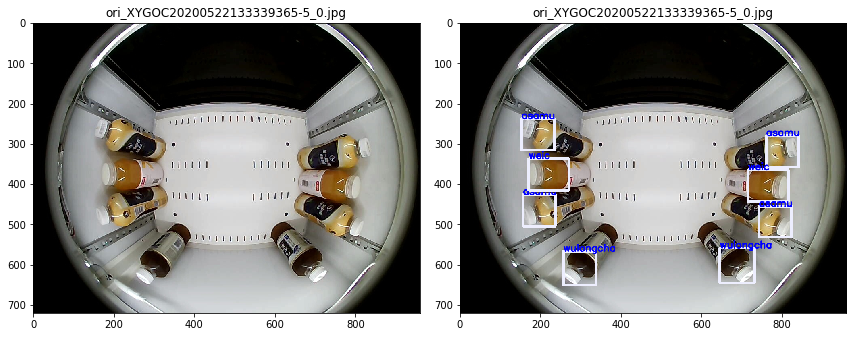

In [ ]:
# 因为数据已经分好了不同的集合 现在把不同集合读取出来

TRAIN_DIR = DATA_PATH + 'train_list.txt'
VAL_DIR   = DATA_PATH + 'val_list.txt'
TEST_DIR  = DATA_PATH + 'test_list.txt'

name2id = get_goods_names()
train_records = get_annotations(name2id, TRAIN_DIR)
print('--train_records done--')
val_records = get_annotations(name2id, VAL_DIR)
print('--val_records done--')
test_records = get_annotations(name2id, TEST_DIR)
print('--test_records done--')

# 取一条数据看看数据结构和对应图片结果
%matplotlib inline
print(train_records[0])
print(DATA_PATH + train_records[0]['img_file'])
show_some_result([DATA_PATH + train_records[0]['img_file']])

## 图片数据读取
`get_img_data_from_file()`函数可以返回图片数据的数据，它们是图像数据img，真实框坐标goods_boxes，真实框包含的物体类别goods_labels，图像尺寸scales。

In [ ]:
# 数据读取
import cv2

def get_box(goods_box, goods_class):
    # 对于一般的检测任务来说，一张图片上往往会有多个目标物体
    # 设置参数MAX_NUM = 40， 即一张图片最多取40个真实框；
    # 如果真实框的数目少于40个，则将不足部分的goods_box, goods_class和goods_score的各项数值全设置为0
    MAX_NUM = 40
    goods_box2 = np.zeros((MAX_NUM, 4))
    goods_class2 = np.zeros((MAX_NUM,))
    for i in range(len(goods_box)):
        if i >= MAX_NUM:
            break
        goods_box2[i, :] = goods_box[i, :]
        goods_class2[i] = goods_class[i]
    return goods_box2, goods_class2

def get_img_data_from_file(record):
    """
    voc_rec = {
        'img_file': img_path,
        'img_id': img_id,
        'h': img_h,
        'w': img_w,
        'goods_class': goods_class,
        'goods_box': goods_box,
        }
    """
    img_path = record['img_file']
    h = record['h']
    w = record['w']
    goods_class = record['goods_class']
    goods_box = record['goods_box']

    img = cv2.imread(DATA_PATH + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # # check if h and w in record equals that read from img
    # assert img.shape[0] == int(h), \
    #          "image height of {} inconsistent in record({}) and img file({})".format(
    #            im_file, h, img.shape[0])

    # assert img.shape[1] == int(w), \
    #          "image width of {} inconsistent in record({}) and img file({})".format(
    #            im_file, w, img.shape[1])

    goods_boxes, goods_labels = get_box(goods_box, goods_class)

    # goods_box 用相对值
    goods_boxes[:, 0] = goods_boxes[:, 0] / float(w)
    goods_boxes[:, 1] = goods_boxes[:, 1] / float(h)
    goods_boxes[:, 2] = goods_boxes[:, 2] / float(w)
    goods_boxes[:, 3] = goods_boxes[:, 3] / float(h)
  
    return img, goods_boxes, goods_labels, (h, w)

In [ ]:
img, goods_boxes, goods_labels, scale = get_img_data_from_file(train_records[0])
print(img.shape, goods_boxes.shape, goods_labels.shape, scale)

(720, 960, 3) (40, 4) (40,) (720.0, 960.0)


## 使用飞桨高层API快速实现数据增强
飞桨提供了拿来即用的数据增强方法，详细可查阅paddle.vision.transforms模块，transforms模块中提供了数十种数据增强方式，包括亮度增强(adjust_brightness)，对比度增强(adjust_contrast)，随机裁剪(RandomCrop)等等。

read image from file JPEGImages/ori_XYGOC20200522133339365-5_0.jpg


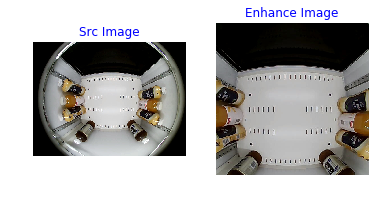

In [ ]:
#对图像随机裁剪
# 从paddle.vision.transforms模块中import随机剪切的API RandomCrop
from paddle.vision.transforms import RandomCrop
from paddle.vision.transforms import BrightnessTransform
from PIL import Image, ImageEnhance
%matplotlib inline
def visualize(srcimg, img_enhance):
    # 图像可视化
    plt.figure(num=2, figsize=(6,12))
    plt.subplot(1,2,1)
    plt.title('Src Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(srcimg) # 显示原图片

    plt.subplot(1,2,2)
    plt.title('Enhance Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(img_enhance)

image_path = train_records[0]['img_file']
print("read image from file {}".format(image_path))
srcimg = Image.open(DATA_PATH + image_path)

# RandomCrop是一个python类，需要事先声明
#RandomCrop还需要传入剪切的形状，这里设置为540
transform1 = RandomCrop(540)

# BrightnessTransform是一个python类，需要事先声明
transform2 = BrightnessTransform(0.4)


# 将图像转换为PIL.Image格式
srcimg = Image.fromarray(np.array(srcimg))
# 调用声明好的API实现随机剪切
img_res = transform1(srcimg)
img_res = transform2(img_res)

# 可视化结果
visualize(srcimg, np.array(img_res))

## 批量数据读取与加速
下面的代码实现了批量数据读取。

In [ ]:
# 获取一个批次内样本随机缩放的尺寸
def get_img_size(mode):
    if (mode == 'train') or (mode == 'valid'):
        inds = np.array([0,1,2,3,4,5,6,7,8,9])
        ii = np.random.choice(inds)
        img_size = 540 + ii * 32
    else:
        img_size = 540
    return img_size

# 将 list形式的batch数据 转化成多个array构成的tuple
def make_array(batch_data):
    img_array = np.array([item[0] for item in batch_data], dtype = 'float32')
    goods_box_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    goods_labels_array = np.array([item[2] for item in batch_data], dtype = 'int32')
    img_scale = np.array([item[3] for item in batch_data], dtype='int32')
    return img_array, goods_box_array, goods_labels_array, img_scale

## 定义数据集结构

In [ ]:
import paddle

# 定义数据读取类，继承Paddle.io.Dataset
class GoodsDataset(paddle.io.Dataset):
    def  __init__(self, datadir, mode='train'):
        self.datadir = datadir
        name2id = get_goods_names()
        self.records = get_annotations(name2id, datadir)

    def __getitem__(self, idx):
        record = self.records[idx]
        img, goods_box, goods_labels, img_shape = get_img_data_from_file(record)
        return img, goods_box, goods_labels, np.array(img_shape)

    def __len__(self):
        return len(self.records)

数据集类的测试（调用定义好的数据集类，参考章节[1.2]的文档示例）

In [ ]:
# 创建数据集
train_dataset = GoodsDataset(TRAIN_DIR, mode='train')
val_dataset   = GoodsDataset(VAL_DIR,   mode='val')
test_dataset  = GoodsDataset(TEST_DIR,  mode='test')

# # 查看数据集
img, goods_boxes, goods_labels, scale = train_dataset[0]
print(img.shape, goods_boxes.shape, goods_labels.shape, scale.shape)

(720, 960, 3) (40, 4) (40,) (2,)


In [ ]:
# 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
# 环境:至尊GPU 使用普通版 batch_size 不能设置太大，建议2,
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=250,
    shuffle=True,
    num_workers=1,
    drop_last=False)

for step, data in enumerate(train_dataloader):
    img, goods_boxes, goods_labels, scale = data
    print(step, img.shape, goods_boxes.shape, goods_labels.shape, scale.shape)

0 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
1 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
2 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
3 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
4 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
5 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
6 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
7 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
8 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
9 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
10 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
11 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
12 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
13 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
14 [250, 720, 960, 3] [250, 40, 4] [250, 40] [250, 2]
15 [46, 720, 960, 3] [46, 40, 4] [46, 40] [46, 2]


In [ ]:
!pip install lxml
!pip install paddlex
!pip install paddle2onnx
!pip install paddlex==2.0.0rc4 -i https://mirror.baidu.com/pypi/simple
!pip install cython  
!pip install pycocotools

## 使用VOCDetection套件进行训练

In [ ]:
import paddlex as pdx
from paddlex import transforms as T

# 定义训练和验证时的transforms
# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/dygraph/docs/apis/transforms/transforms.md
train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=-1), T.RandomDistort(),
    T.RandomExpand(im_padding_value=[123.675, 116.28, 103.53]), T.RandomCrop(),
    T.RandomHorizontalFlip(), T.BatchRandomResize(
        target_sizes=[
            320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704,
            736, 768
        ],
        interp='RANDOM'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = T.Compose([
    T.Resize(
        target_size=640, interp='CUBIC'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = pdx.datasets.VOCDetection(
    data_dir='data/data91732',
    file_list='data/data91732/train_list.txt',
    label_list='data/data91732/labels.txt',
    transforms=train_transforms,
    shuffle=True)

eval_dataset = pdx.datasets.VOCDetection(
    data_dir='data/data91732',
    file_list='data/data91732/val_list.txt',
    label_list='data/data91732/labels.txt',
    transforms=eval_transforms,
    shuffle=False)

num_classes = len(train_dataset.labels)
model = pdx.det.PPYOLOv2(num_classes=num_classes, backbone='ResNet50_vd_dcn')

model.train(
    num_epochs=10,
    train_dataset=train_dataset,
    train_batch_size=4,
    eval_dataset=eval_dataset,
    pretrain_weights='COCO',
    learning_rate=0.005 / 12,
    warmup_steps=1000,
    warmup_start_lr=0.0,
    lr_decay_epochs=[105, 135, 150,210,240],
    save_interval_epochs=1,
    save_dir='output/ppyolov2_r50vd_dcn')

In [ ]:
!paddlex --export_inference --model_dir=output/ppyolov2_r50vd_dcn/best_model --save_dir=./inference_model

In [ ]:
test_list = []
with open("/home/aistudio/data/data91732/test_list.txt", "r") as f:
    for line in f.readlines():
        line = line.strip('\n')  #去掉列表中每一个元素的换行符
        line = line.split(' ')[0]
        # print(line)
        test_list.append('data/data91732/' + line)

2022-02-25 18:45:59 [INFO]	Model[PPYOLOv2] loaded.
2022-02-25 18:45:59 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021042115280707701IK-3_0.jpg
2022-02-25 18:45:59 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021041417191941701IK-4_0.jpg
2022-02-25 18:45:59 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC20200522133029961-5_0.jpg
2022-02-25 18:45:59 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021042109403443201IK-3_0.jpg
2022-02-25 18:46:00 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021031508481702602A7-3.jpg
2022-02-25 18:46:00 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021042211231164901IK-4_0.jpg
2022-02-25 18:46:00 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021042017564517301IK-4_0.jpg
2022-02-25 18:46:00 [INFO]	The visualized result is saved at ./visualize_ori_XYGOC2021042115130893401IK-4_0.jpg
2022-02-25 18:46:00 [INFO]	The visualized result is saved a

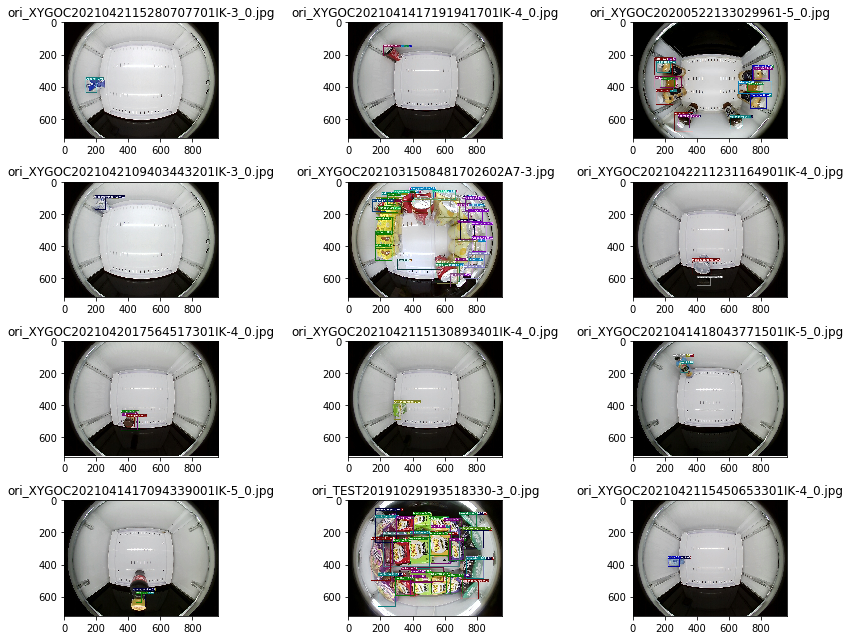

In [ ]:
import paddlex as pdx
import os

model = pdx.load_model('/home/aistudio/inference_model/inference_model')
%matplotlib inline
for i in test_list[100:112]:
    # predict接口并未过滤低置信度识别结果，用户根据需求按score值进行过滤
    result = model.predict(i)
    # 可视化结果存储在./visualized_test.jpg, 见下图
    pdx.det.visualize(i, result, threshold=0.02, save_dir='./')

count = 1
plt.figure(figsize=(12,9))
for i in test_list[100:112]:
    plt.subplot(4,3,count)
    plt.title(i.split('/')[-1])
    plt.imshow(cv2.imread('./visualize_' + i.split('/')[-1])[:, :, ::-1])
    # 不加[:, :, ::-1]会导致颜色不对，但这不是色差问题，是cv2的图像对象使用的是bgr, plt绘图显示图像对象使用的是 rgb，逆序即可
    count+=1

plt.tight_layout()
plt.show()

## 训练过程可视化

In [ ]:
!pip install visualdl==2.0.4

In [5]:
"""
通过 VisualDL-Service 共享可视化结果
此功能是 VisualDL 2.0.4 新添加的功能，只需要一行代码 visualdl service upload 即可以将自己的log文件上传到远端，
如果你没有安装 VisualDL 2.0.4 ，你需要使用命令pip install visualdl==2.0.4安装
执行下面的代码之后，会访问生成的链接
"""

!visualdl service upload --logdir ./output/ppyolov2_r50vd_dcn/vdl_log/
# https://paddlepaddle.org.cn/paddle/visualdl/service/app?id=f63515ed762f180f6095b506c423a66e

Uploading file `./output/ppyolov2_r50vd_dcn/vdl_log/vdlrecords.1645775327.log`
View your visualization results at: `https://paddlepaddle.org.cn/paddle/visualdl/service/app?id=f63515ed762f180f6095b506c423a66e`.


![](https://ai-studio-static-online.cdn.bcebos.com/a7198cd619904aee885fe4c53ac6d2fa42b1676a999e4003a83fa5cbc8828826)
![](https://ai-studio-static-online.cdn.bcebos.com/fbd865b6ff724fc28d1200b36fdf057207b01c504e7346b5b3910f7cbd19ec46)
![](https://ai-studio-static-online.cdn.bcebos.com/cd8b8cb541d44097b0531a8777e6b1ee791e2e8689d946d3b4c77530739ac7ee)


## 总结与升华
太菜了，只是对他人已经实现的项目进行了复现，这识别率属实是有些拉，因为训练的时间比较短，之后的话可以多训练几次...

## 个人总结
太菜了，不过基本熟悉了这个平台的一些操作，还是挺方便的，以后打比赛也可以利用这个平台进行训练，知识还有很多，需要自己去学习，多花时间钻研钻研，瑞斯拜...

目标检测还是挺有意思的，以后可以尝试一些别的项目比如烟雾检测，车道线检测，裂缝检测之类的，希望能够在理论和实践中知行合一，不断进取，努力学习，做出更优质一些的项目，salute！

## 提交链接
aistudio链接：[https://aistudio.baidu.com/aistudio/projectdetail/3503803](https://aistudio.baidu.com/aistudio/projectdetail/3503803)

github链接：[https://github.com/JunyaoHu/PaddlePaddleDemo](https://github.com/JunyaoHu/PaddlePaddleDemo)

gitee链接：[https://gitee.com/hujunyao37201/PaddlePaddleDemo](https://gitee.com/hujunyao37201/PaddlePaddleDemo)